# ieee-cis Fraud Detection
## EDA 부터 XGB hyperopt로 모델링까지
**[참고한 커널](https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt)**

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#standard plotly imports
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode

#import cufflinks
import plotly.figure_factory as ff

#using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)

#preprocessing, modeling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
import xgboost as xgb

#hyperparameter optimization modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
print(os.listdir("../input"))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [3]:
%%time
df_id = pd.read_csv('../input/train_identity.csv')
df_trans = pd.read_csv('../input/train_transaction.csv')

Wall time: 34.3 s


In [19]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns = ['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index: # 즉 각 value에 대하여
        summary.loc[summary['Name'] == name, 'Entropy'] = round(
        stats.entropy(df[name].value_counts(normalize = True), base=2), 2)
        # stats.entropy는 뭔지 찾아보기
    return summary

# DF size를 줄이는 함수
# def reduce_mem_usage(df, verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics: # numerics 중 해당하는 값 있다면?
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int16)
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16.max):
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32.max):
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
    
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose:
#         print('Mem. usage decreased to {:5.2f}Mb to {:.1f} reduction'.format(
#         end_mem, 100 * (start_mem - end_mem) / start_mem))
    
#     return df

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

def CalcOutliers(df_num):
    # array의 평균, 표준편차 계산
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    
    # 상한, 하한 범위 설정
    cut = data_std * 3
    
    # 상한, 하한값 설정
    lower, upper = data_mean - cut, data_mean + cut
    
    # outliers values 생성
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]
    
    # array without outlier values. lower, upper 와 같은 경우는 뺌??
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lower outliers: %d' % len(outliers_lower))
    print('Identified upper outliers: %d' % len(outliers_higher))
    print('Total outlier observations: %d' % len(outliers_total))
    print('Non-outlier observations: %d' % len(outliers_removed))
    print('Total percentual of Outliers:', round((
        len(outliers_total) / len(outliers_removed)) * 100, 4))
    
    return

In [5]:
%%time
# Reducing memory
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Wall time: 2min 41s


In [5]:
resumetable(df_trans)[:25] #25행(25번째 칼럼)까지만 출력

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Thrid Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


In [5]:
# imbalanced 되어 있는지 확인 -> Fraud는 3.5% 뿐!
df_trans['isFraud'].value_counts() / df_trans.shape[0] * 100

0    96.500999
1     3.499001
Name: isFraud, dtype: float64

In [24]:
print(df_id.shape)
df_id.head()

(144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


## Target Distribution

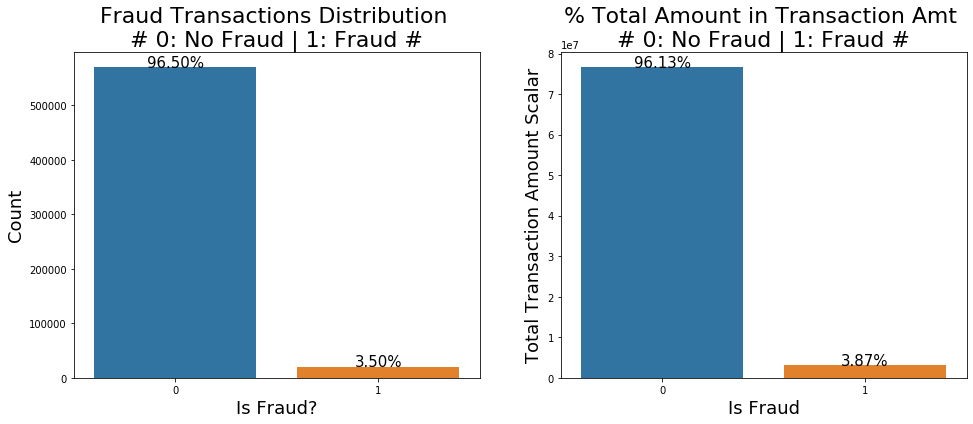

In [12]:
# 굳이 float16 -> float64로 하는 이유가?
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans) #앞으로 그래프에서 쓰일 변수
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum() #총 거래량 합
plt.figure(figsize=(16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data=df_trans)
g.set_title('Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #',
           fontsize=22)
g.set_xlabel('Is Fraud?', fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    # 아래코드는 위치(1,2번째 인자)와 값을 그래프에 넣어주는 함수인 듯
    g.text(p.get_x() + p.get_width()/2., height + 3, 
          "{:1.2f}%".format(height / total * 100), ha="center", fontsize=15)

#아래 코드에서 바깥 괄호는 왜 씌우는 건지?
perc_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum()
perc_amt = perc_amt.reset_index()

plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt', dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #",
            fontsize=22)
g1.set_xlabel("Is Fraud", fontsize=18)
g1.set_ylabel("Total Transaction Amount Scalar", fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width() / 2., height + 3,
           '{:1.2f}%'.format(height / total_amt * 100), ha = "center",
           fontsize=15)
    
plt.show()

- Fraud 비율(3.5%)과 Transaction amount 중에서 Fraud가 차지하는 비율(3.87%)이 유사한 것이 눈에 띔

In [49]:
# TransAmt의 quantile 살펴보기
print("Transaction Amounts Quantiles:")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75,
                                          .9, .975, .99, 1]))

Transaction Amounts Quantiles:
0.010        9.242188
0.025       14.500000
0.100       25.953125
0.250       43.312500
0.500       68.750000
0.750      125.000000
0.900      275.250000
0.975      648.262500
0.990     1104.000000
1.000    31936.000000
Name: TransactionAmt, dtype: float64


In [50]:
df_trans['TransactionAmt'].describe()

count    590540.000000
mean        135.027347
std         239.157438
min           0.250977
25%          43.312500
50%          68.750000
75%         125.000000
max       31936.000000
Name: TransactionAmt, dtype: float64

### Plotting Transaction Amount Values Distribution

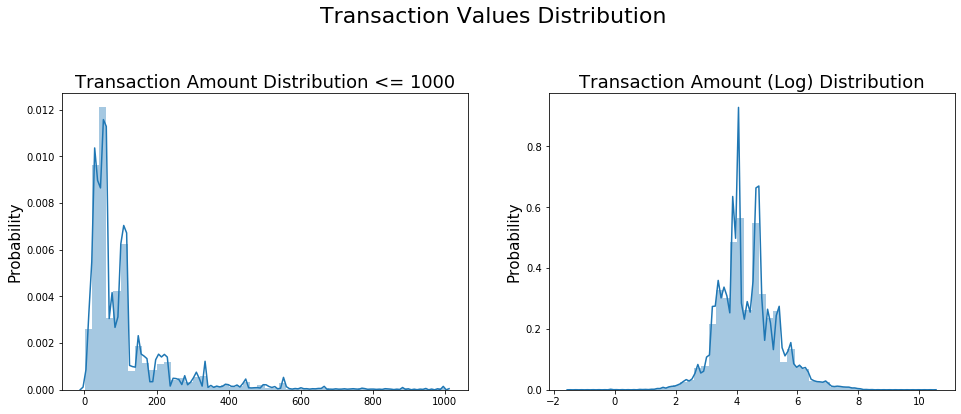

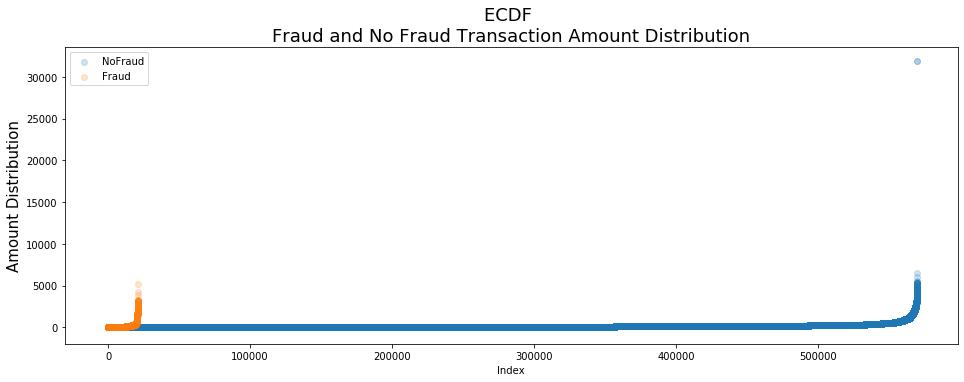

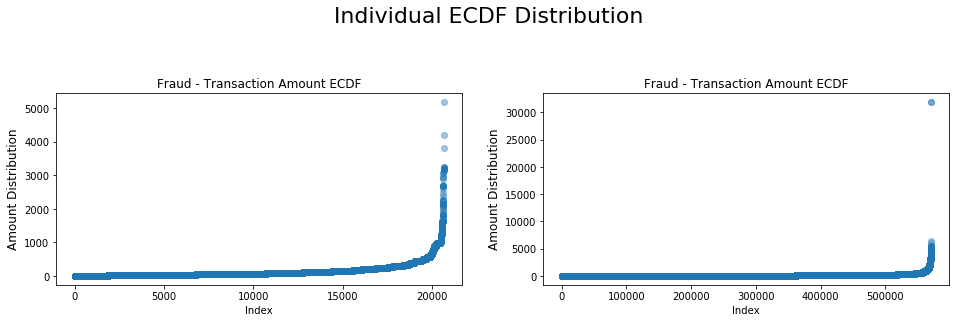

In [60]:
# 1행
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22) #super title?
plt.subplot(221)
g = sns.distplot(df_trans[df_trans['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribution <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribution", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

# 2행
plt.figure(figsize=(16, 12))
plt.subplot(212)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                np.sort(
                df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values),
        label = 'NoFraud', alpha=.2)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                np.sort(
                df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values),
        label= 'Fraud', alpha=.2)
g4 = plt.title("ECDF \nFraud and No Fraud Transaction Amount Distribution",
              fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

# 3행 -> 2행의 결과를 Fraud, No Fraud 따로 시각화하기
plt.figure(figsize=(16, 12))
plt.subplot(321)
g = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
               np.sort(
                df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values),
        label = 'Fraud', alpha=.4)
plt.title("Fraud - Transaction Amount ECDF")
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
g1 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
               np.sort(
                df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values),
        label = 'No Fraud', alpha=.4)
g1 = plt.title("Fraud - Transaction Amount ECDF")
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=12)

plt.suptitle("Individual ECDF Distribution", fontsize=22)

plt.show()

### Fraud, No Fraud Transaction의 quantile 확인

In [62]:
print(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].mean())
print(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].mean())

134.51185725859278
149.24435261605134


In [66]:
pd.concat([df_trans[df_trans['isFraud'] == 1]['TransactionAmt']\
          .quantile([.01, .1, .25, .5, .75, .9, .99]).reset_index(),
           df_trans[df_trans['isFraud'] == 0]['TransactionAmt']\
          .quantile([.01, .1, .25, .5, .75, .9, .99]).reset_index()],
         axis=1, keys=['Fraud', 'No Fraud'])
# 유사한 quantile을 보임

Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01       6.739453     0.01       9.511875
1  0.10      18.937500     0.10      26.312500
2  0.25      35.031250     0.25      43.968750
3  0.50      75.000000     0.50      68.500000
4  0.75     161.000000     0.75     120.000000
5  0.90     335.000000     0.90     267.100000
6  0.99     994.000000     0.99    1104.000000

### Transaction Amount Outliers
- 평균 +- 3td

In [71]:
CalcOutliers(df_trans['TransactionAmt'])

Identified lower outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers: 1.7395


- 전체 행 중 1.74% 정도인 1만개 정도의 행에 outlier가 있음

## Product Feature 알아보기
- productCD Distribution
- product에 따른 Fraud의 분포
- product별로 Transaction Amount가 다른지 확인

isFraud ProductCD    NoFraud      Fraud
0               C  88.312731  11.687269
1               H  95.233769   4.766231
2               R  96.217406   3.782594
3               S  94.100447   5.899553
4               W  97.960061   2.039939


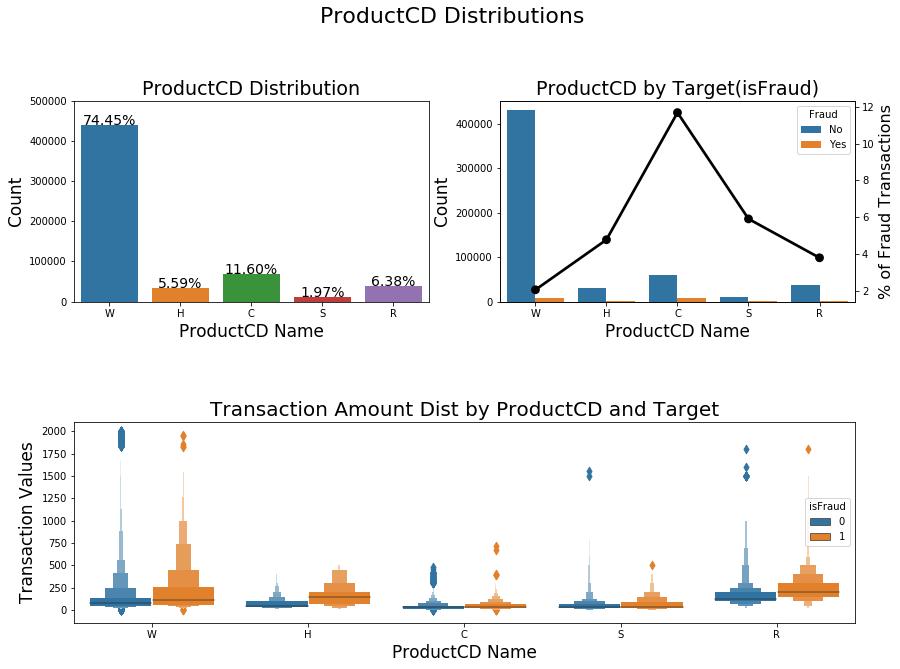

In [94]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'],
                 normalize='index') * 100
tmp = tmp.reset_index()
# 칼럼명이 0,1인 칼럼의 이름 바꾸기. reset_index 하고 난 이후이므로
# Fraud, No Fraud가 구분됨
tmp.rename(columns = {0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp)

plt.figure(figsize=(14, 10))
plt.suptitle("ProductCD Distributions", fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0, 500000) # 바 위에 숫자 표기 위해 조금 늘림
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width() / 2., height + 3,
          '{:1.2f}%'.format(height / total * 100), ha="center", fontsize=14)

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx() #반대쪽(y축) 인덱스대로 그리기
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black',
                  order=['W', 'H', 'C', 'S', 'R'], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("ProductCD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
#boxenplot -> boxplot보다 좀더 진화된 plot인 듯
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud',
                  data=df_trans[df_trans['TransactionAmt'] <= 2000])
g3.set_title("Transaction Amount Dist by ProductCD and Target",
            fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

#그림 간 간격 조정
plt.subplots_adjust(hspace=0.6, top=0.85)

plt.show()

- 1) W,C,R 그룹 빈도가 많음
- 2) C 그룹에서 Fraud 비율이 많음
- 3) W,H,R 그룹에서 Fraud의 거래량(**주황색**)이 Non-Fraud 거래량보다 약간 더 많음

## Card Feature 알아보기
- competition 설명에 따라 card feature는 범주형(card1 ~ card6)
- 각 feature에 따라 Fraud, Non-Fraud 비율 살펴보기
- 6개 변수 중 4개는 numeric, 2개는 범주형(카드 회사와 카드 종류(직불, 신용))
- 2개의 범주형 변수(card4, 6)는 단순하므로, card1,2,3,5에 대해 살펴봄

In [95]:
# card feature 살펴보기
resumetable(df_trans[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Thrid Value,Entropy
0,card1,int16,0,13553,13926,2755,4663,9.97
1,card2,float16,8933,500,NaN,404,490,6.32
2,card3,float16,1565,114,150,150,150,0.68
3,card4,object,1577,4,discover,mastercard,visa,1.09
4,card5,float16,4259,119,142,102,166,2.66
5,card6,object,1571,4,credit,credit,debit,0.82


- card2 ~ card6은 결측치 있음. 뒤에서 다시 다룸

In [97]:
print("Card Feature Quantiles:")
print(df_trans[['card1', 'card2', 'card3', 'card5']].quantile([
    .01, .025, .1, .25, .5, .75, .975, .99, 1
]))

Card Feature Quantiles:
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0
1.000  18396.0  600.0  231.0  237.0


- 상대적으로 card1, card2가 넓게 분포되어 있음 -> log 취하기

- card3, card5의 value_counts를 보면 최대 10만 대인 count도 있음
- **따라서 count가 낮은(<200, <300) 기타 범주는 Others로 묶기**

In [8]:
print(df_trans.card3.value_counts().head())
print(df_trans.card5.value_counts().head())
df_trans.loc[df_trans['card3'].isin(df_trans['card3'].value_counts()[
    df_trans['card3'].value_counts() < 200].index), 'card3'] = 'Others'
df_trans.loc[df_trans['card5'].isin(df_trans['card5'].value_counts()[
    df_trans['card5'].value_counts() < 300].index), 'card5'] = 'Others'

150.0    521287
185.0     56346
106.0      1571
146.0      1252
144.0      1252
Name: card3, dtype: int64
226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
Name: card5, dtype: int64


### card1, 2, 3 분포 시각화

isFraud card3    NoFraud     Fraud
0         100  95.049505  4.950495
1         102  97.608696  2.391304
2         106  98.472311  1.527689
3         117  98.126951  1.873049
4         119  90.666667  9.333333


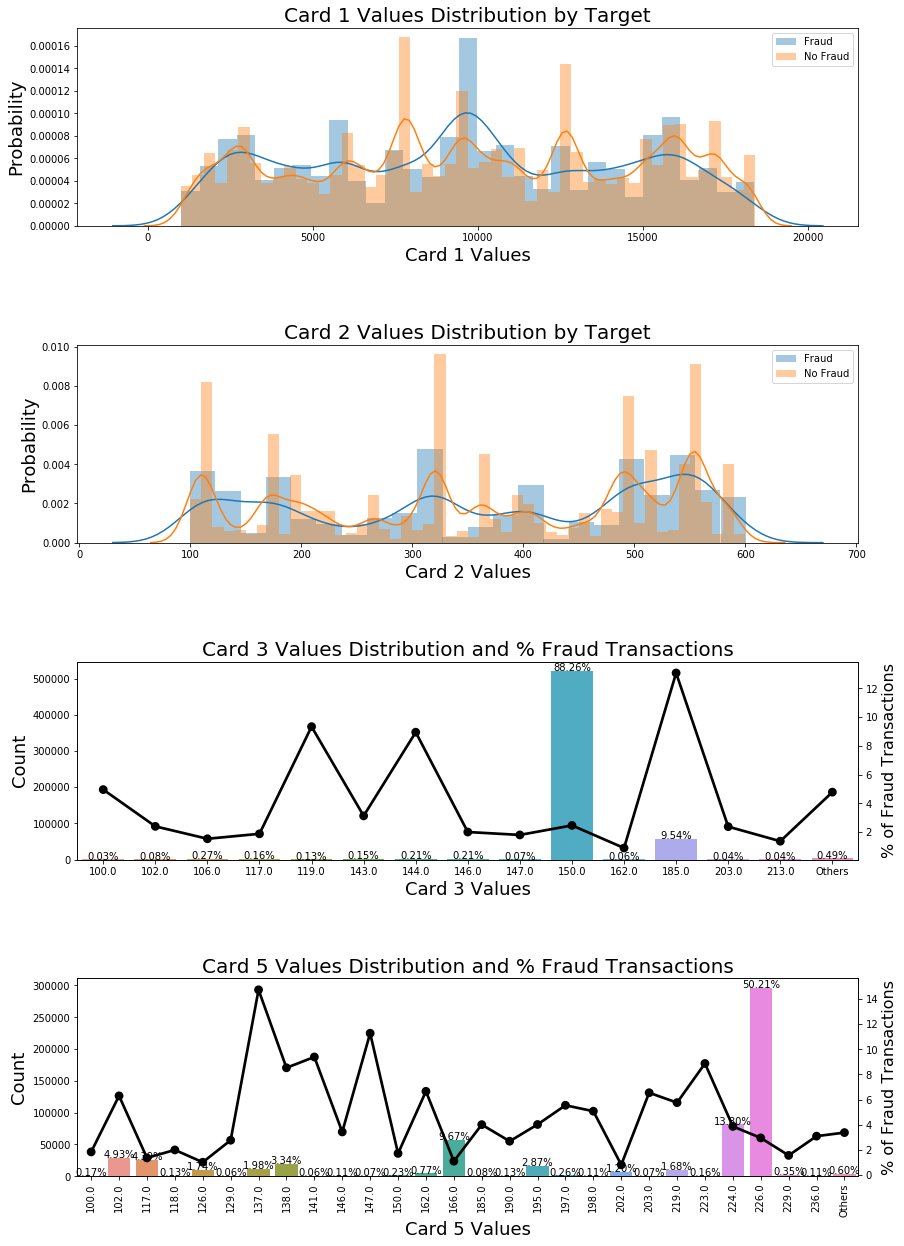

In [39]:
# card3, card5별 Fraud %를 보기 위해 crosstab 생성
# crosstab을 하면 card3별 Fraud=0 vs Fraud=1이 나뉘기 때문에, 비율이 보임
tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp.head())

tmp2 = pd.crosstab(df_trans['card5'], df_trans['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14, 22))
# 1행 card1 distplot -> 히스토그램과 dist 곡선이 모두 나타남
plt.subplot(411)
g = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card1'], label='No Fraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

# 2행 card2 distplot
plt.subplot(412)
# card2~6은 null 이 있음 -> dropna() 데이터를 시각화
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(),
                 label='Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(),
                 label='No Fraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

# 3행 card3 countplot(히스토그램) + pointplot(꺾은선 그래프)
plt.subplot(413)
g2 = sns.countplot(x='card3', data=df_trans, order=list(tmp['card3'].values))
g2t = g2.twinx()
g2t = sns.pointplot(x='card3', y='Fraud', data=tmp, color='black',
                   order=list(tmp['card3'].values))
g2t.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % Fraud Transactions",
            fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x() + p.get_width() / 2., height + 25,
           '{:1.2f}%'.format(height / total * 100), ha='center')

# 4행 card 5 
plt.subplot(414)
g3 = sns.countplot(x='card5', data=df_trans, order=tmp2['card5'].values)
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, color='black',
                   order=tmp2['card5'].values)
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % Fraud Transactions",
            fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(), rotation=90) # xlabel 90도 회전
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x() + p.get_width() / 2., height + 25,
           '{:1.2f}%'.format(height / total * 100), ha='center')
    
plt.subplots_adjust(hspace=0.6, top=0.85)
plt.show()

- card3
    - 150, 185가 가장 흔한 value
    - Fraud %가 가장 높은 value -> 185, 119, 144. 8% 정도 이상
- card5
    - 226, 224, 166이 전체 데이터의 73% 정도 차지함
    - 137, 147, 141 -> count는 적지만 Fraud %가 높음. 8% 정도 이상

### Card 4
- 위에서 한 코드 토대로 내가 짜 보기

isFraud             card4    NoFraud     Fraud
0        american express  97.130163  2.869837
1                discover  92.271839  7.728161
2              mastercard  96.566905  3.433095
3                    visa  96.524390  3.475610


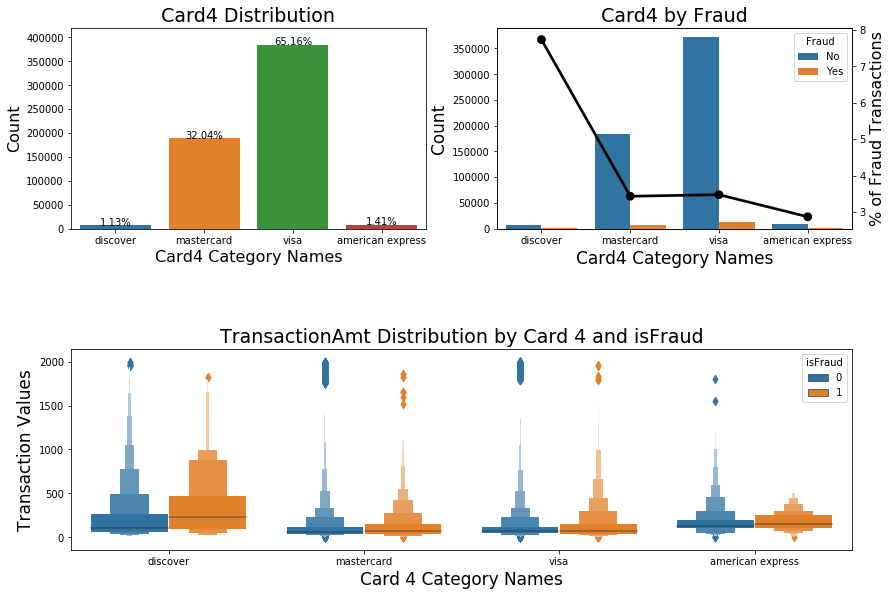

In [59]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp)

plt.figure(figsize=(14, 10))
# 1행
plt.subplot(221)
g = sns.countplot(x='card4', data=df_trans)
g.set_ylim(0, 420000)
g.set_title("Card4 Distribution", fontsize=19)
g.set_xlabel("Card4 Category Names", fontsize=16)
g.set_ylabel("Count", fontsize=16)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width() / 2., height + 3,
          '{:1.2f}%'.format(height / total * 100), ha = 'center')
    
plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
# g1 x(card4) 순서에 맞게 정렬(order)
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, color='black',
                  legend=False,
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Fraud", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
# boxenplot -> x, y, hue가 모두 있어야 함?
g2 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
                   data=df_trans[df_trans['TransactionAmt'] <= 2000])
g2.set_title("TransactionAmt Distribution by Card 4 and isFraud",
            fontsize=19)
g2.set_xlabel("Card 4 Category Names", fontsize=17)
g2.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)
plt.show()

### card4(결제회사 종류)
- 97%가 visa(65%) or mastercard(32%)
- discover가 visa, mastercard(2~3%)에 비해 Fraud%가 월등히 높음(7.7%)
- 거래량을 보면 유의한 차이는 별로 보이진 않음. discover에서 Fraud의 거래량이 살짝 큼

### card6(카드 종류)
- 92% 정도가 debit(74.5%) or credit(25%)
- charge card, debit or credit은 Fraud가 없음
- Fraud%는 credit(6.7%)이 debit(2.4%)에 비해 높음

In [61]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns = {0:'NoFraud', 1:'Fraud'}, inplace=True)
tmp

isFraud,card6,NoFraud,Fraud
0,charge card,100.000000,0.000000
1,credit,93.321520,6.678480
2,debit,97.573749,2.426251
3,debit or credit,100.000000,0.000000


## M1-M9 feature
- 아래와 같이 상당한 비율의 결측치들이 있음
- 결측치는 'Miss'로 대체하기

In [62]:
resumetable(df_trans[['M1','M2','M3','M4','M5','M6','M7','M8','M9']])

Dataset Shape: (590540, 9)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Thrid Value,Entropy
0,M1,object,271100,2,T,NaN,T,0.00
1,M2,object,271100,2,T,NaN,T,0.49
2,M3,object,271100,2,T,NaN,T,0.75
3,M4,object,281444,3,M2,M0,M0,1.31
4,M5,object,350482,2,F,T,F,0.99
5,M6,object,169360,2,T,T,F,1.00
6,M7,object,346265,2,NaN,NaN,F,0.57
7,M8,object,346252,2,NaN,NaN,F,0.95
8,M9,object,346252,2,NaN,NaN,F,0.63


In [6]:
# plot 그리는 함수 정의
for col in ['M1','M2','M3','M4','M5','M6','M7','M8','M9']:
    df_trans[col] = df_trans[col].fillna('Miss')

def ploting_dist_ratio(df, col, lim = 2000):
    # 각 행 1번째 플롯: countplot + pointplot(% Fraud)
    tmp = pd.crosstab(df[col], df['isFraud'], normalize = 'index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns = {0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(20, 5))
    plt.suptitle(f'{col} Distribution', fontsize=22)
    
    plt.subplot(121)
    #여기서 order=list 붙이는 이유는? 속도 빨라지나? 비교해 보기
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    g.set_title(f"{col} Distribution\nCount and % Fraud by each category",
               fontsize=18)
    g.set_ylim(0, 400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(
    tmp[col].values), color='black', legend=False)
    gt.set_ylim(0, 20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=16)
    for p in g.patches:
        height = p.get_height()
        gt.text(p.get_x() + p.get_width() / 2., height + 3,
               '{:1.2f}'.format(height / total * 100), ha='center',
               fontsize=14)
    
    # 각 행 2번째 플롯: boxplot(TransactionAmt) + pointplot(??)
    perc_amt = (df_trans.groupby(['isFraud', col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns = {0: 'NoFraud', 1: 'Fraud'}, inplace=True)
    
    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud',
                    data=df[df['TransactionAmt'] <= lim],
                    order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt,
                       order=tmp[col].values, color='black', legend=False)
    g1t.set_ylim(0, 5)
    g1t.set_ylabel("% Fraud of Total Amount")
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"col Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(US$)")

    plt.subplots_adjust(hspace = 0.4, wspace = 0.35, top = 0.8)
    plt.show()

In [94]:
# 참고할 코드
# unstack -> reset_index와 유사. MultiIndex 중 첫 번째 인덱스를 열로 바꿈!
# perc_amt -> 전체 Transacion Amt 중 해당 카테고리에서 차지하는 비율
perc_amt = (df_trans.groupby(['isFraud', 'M1'])['TransactionAmt'].sum()\
            / total_amt * 100).unstack('isFraud')
perc_amt = perc_amt.reset_index()
perc_amt.rename(columns = {0: 'NoFraud', 1: 'Fraud'}, inplace=True)
perc_amt

isFraud,M1,NoFraud,Fraud
0,F,0.004843,NaN
1,Miss,36.573351,1.969254
2,T,59.554396,1.898156


In [75]:
%%time
# 실행 안되는건 메모리 문젠가?
for col in ['M1','M2','M3','M4','M5','M6','M7','M8','M9']:
    ploting_dist_ratio(df_trans, col, lim = 2500)

Wall time: 0 ns


### M1 ~ M9 정리
- M4를 제외하고는 모두 Miss에서 Fraud % 가 가장 높음
- 아래 crosstab을 보면 M4는 오히려 Miss에서 Fraud % 가 가장 낮음

In [79]:
tmp = pd.crosstab(df_trans['M4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns = {0:'NoFraud', 1:'Fraud'}, inplace=True)
tmp

isFraud,M4,NoFraud,Fraud
0,M0,96.335124,3.664876
1,M1,97.294893,2.705107
2,M2,88.626075,11.373925
3,Miss,98.142792,1.857208


## Addr1, Addr2
- 역시 categorical feature

In [97]:
print("Addr Features quantiles:")
print(df_trans[['addr1', 'addr2']].quantile([
    0.01, 0.025, 0.01, 0.25, 0.5, 0.75, 0.9, 0.975, 0.99
]))

Addr Features quantiles:
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.010  123.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
16.0        55
31.0        47
19.0        33
26.0        25
27.0        20
Name: addr2, dtype: int64


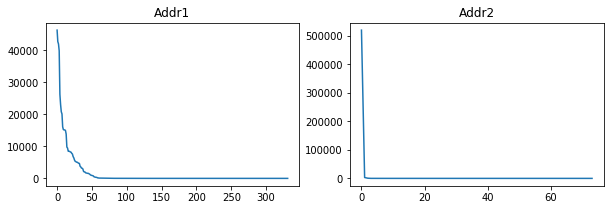

In [113]:
plt.figure(figsize=(10, 3))
g = plt.subplot(121)
plt.plot(df_trans['addr1'].value_counts().values)
g.set_title("Addr1")

g1 = plt.subplot(122)
print(df_trans['addr2'].value_counts().head(10)) #급격하게 줄어듦
plt.plot(df_trans['addr2'].value_counts().values)
g1.set_title("Addr2")
plt.show()

In [9]:
df_trans.loc[df_trans['addr1'].isin(
    df_trans['addr1'].value_counts()[
        df_trans['addr1'].value_counts() <= 5000].index), 'addr1'] = "Others"
df_trans.loc[df_trans['addr2'].isin(
    df_trans['addr2'].value_counts()[
        df_trans['addr2'].value_counts() <= 50].index), 'addr2'] = "Others"

# tmp = pd.crosstab(df_trans['addr1'], df_trans['isFraud'], normalize='index') * 100
# tmp = tmp.reset_index()
# tmp.rename(columns = {0:'NoFraud', 1:'Fraud'}, inplace = True)

In [10]:
# count plot + Amt plot 그리는 함수 (복사함)
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x() + p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()

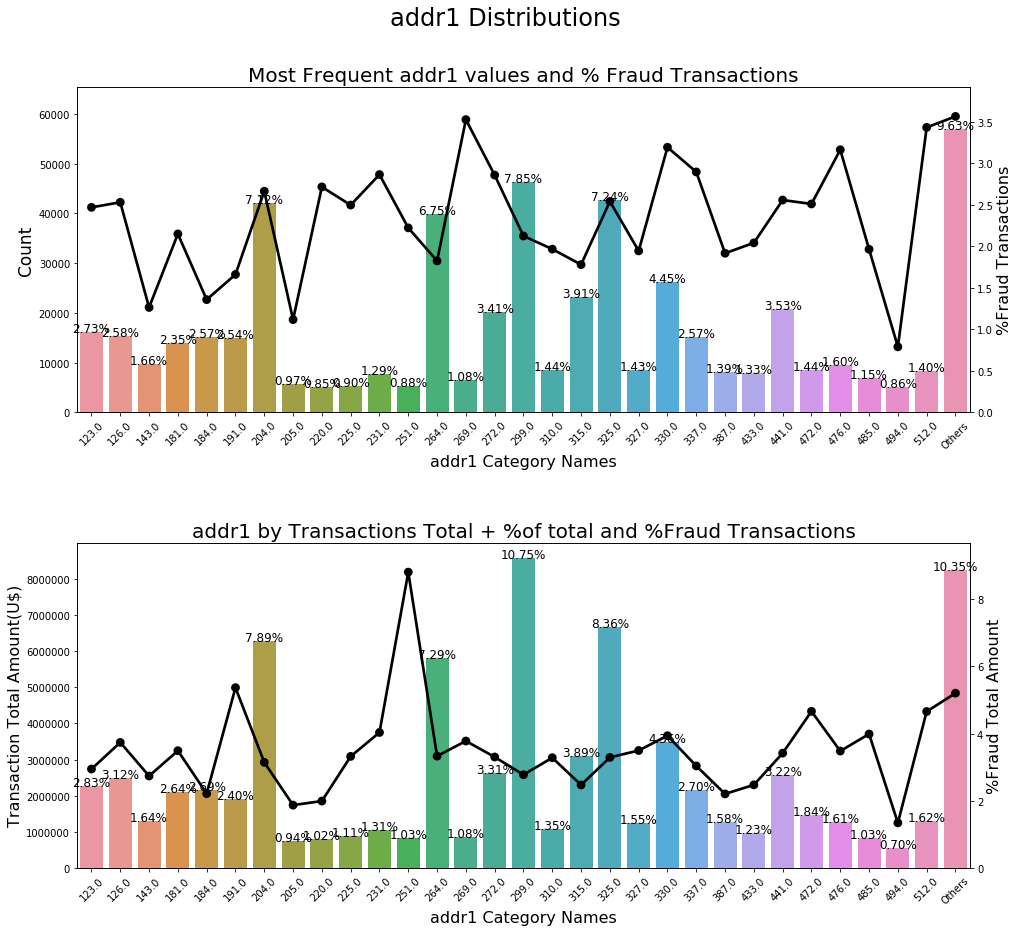

In [24]:
ploting_cnt_amt(df_trans, 'addr1')

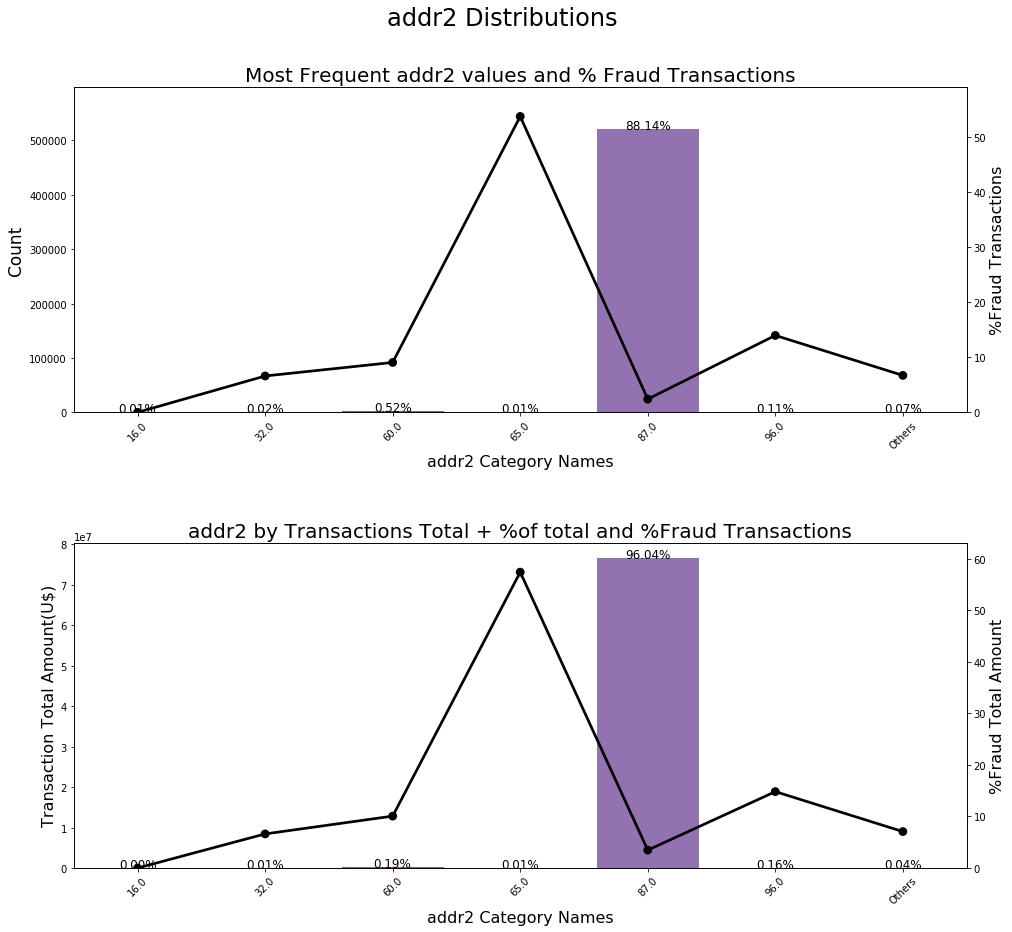

In [134]:
ploting_cnt_amt(df_trans, 'addr2')

### addr1
- count가 큰 범주는 Others, 299, 204
- Fraud % 높은 범주는 Others, 269, 330

### addr2
- 87이 전체 데이터의 88% 차지. TransactionAmt는 전체의 96% 차지
- 65에서 Fraud %가 정말 많이 높음(60% 정도)

## P-email domain

In [119]:
df_trans['P_emaildomain'].value_counts().head() #총 59개의 domain

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
twc.com                230
n

In [14]:
# 겹치는 도메인들이 있음 -> 통합
df_trans.loc[df_trans['P_emaildomain'].str[:5] == 'gmail',
             'P_emaildomain'] = 'Google'
df_trans.loc[df_trans['P_emaildomain'].str[:5] == 'yahoo',
             'P_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'

df_trans.loc[df_trans['P_emaildomain'].isin(
    df_trans.P_emaildomain.value_counts()[df_trans.P_emaildomain.value_counts() <= 500].index),
            'P_emaildomain'] = 'Others'
df_trans.P_emaildomain.fillna("NoInf", inplace=True)

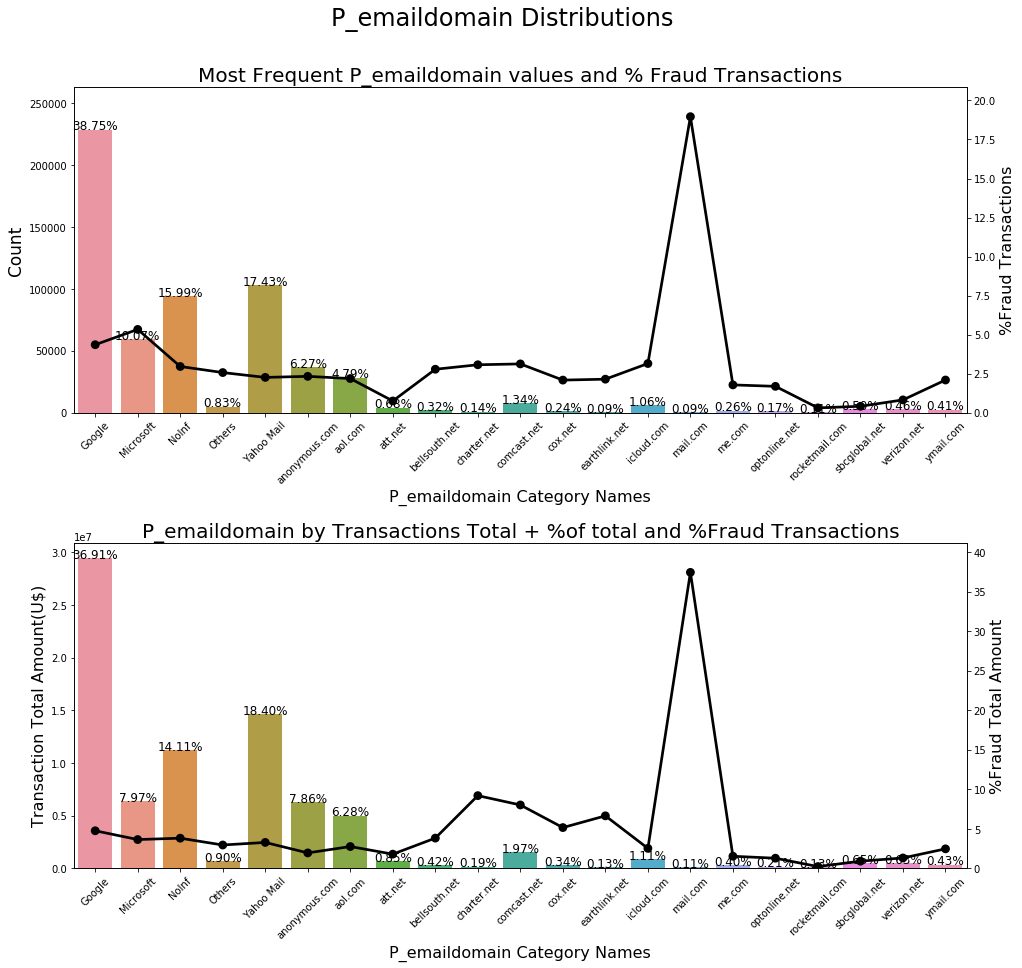

In [15]:
ploting_cnt_amt(df_trans, 'P_emaildomain')

- Google, Microsoft, Yahoo, NoInf(null)이 대부분 차지
- mail.com 도메인의 Fraud %가 20% 정도로 압도적으로 높음

### R-email domain
- 종류가 많음. 역시 종류별로 대체 필요

In [16]:
df_trans.loc[df_trans['R_emaildomain'].str[:5] == 'gmail',
             'R_emaildomain'] = 'Google'
df_trans.loc[df_trans['R_emaildomain'].str[:5] == 'yahoo',
             'R_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'

df_trans.loc[df_trans['R_emaildomain'].isin(
    df_trans.R_emaildomain.value_counts()[df_trans.R_emaildomain.value_counts() <= 300].index),
            'R_emaildomain'] = 'Others'
df_trans.R_emaildomain.fillna("NoInf", inplace=True)

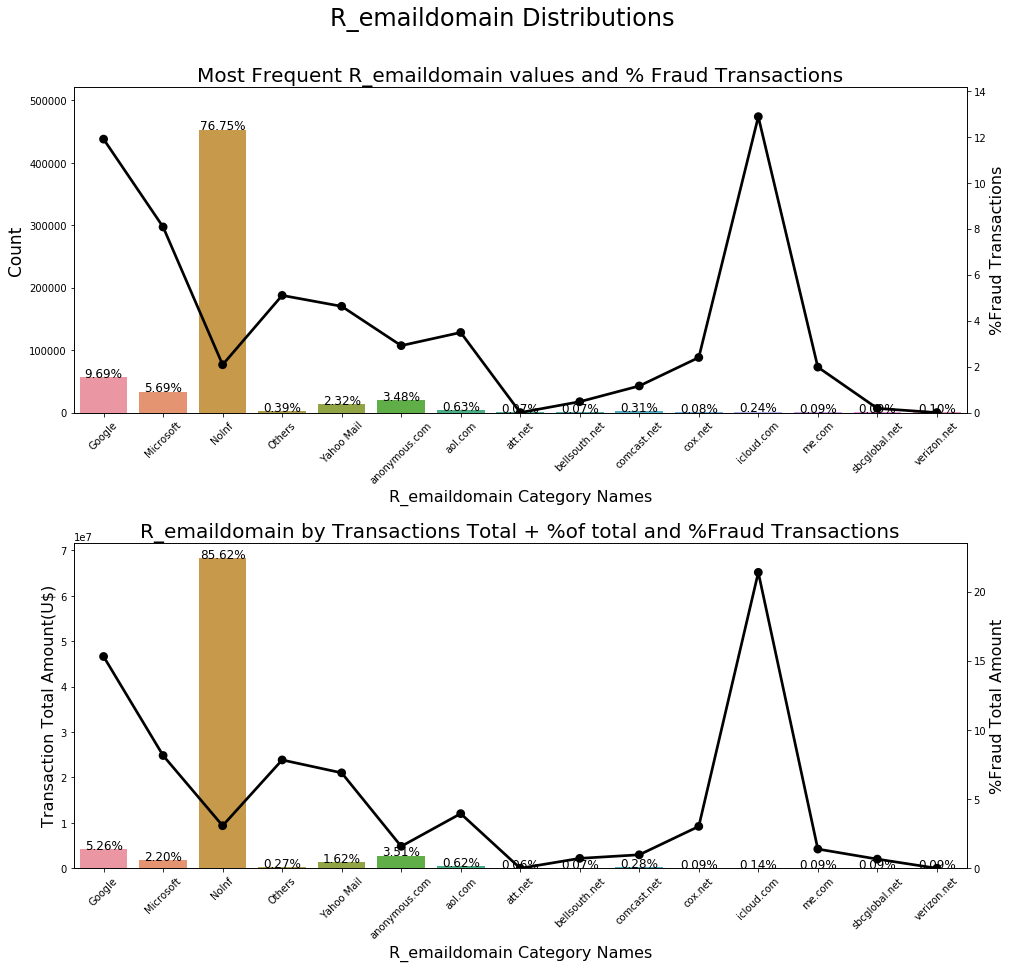

In [23]:
ploting_cnt_amt(df_trans, 'R_emaildomain')

- NoInf(null) 비율(76.8%)이 P_emaildomain(16%)보다는 훨씬 많음
- P_emaildomain처럼 특정 도메인(icloud.com)의 Fraud %가 압도적으로 높음(12% 정도)

## C1-C14 feature

In [20]:
resumetable(df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float16,0,1495,1.0,1.0,1.0,2.72
1,C2,float16,0,1167,1.0,1.0,1.0,2.75
2,C3,float16,0,27,0.0,0.0,0.0,0.04
3,C4,float16,0,1223,0.0,0.0,0.0,1.12
4,C5,float16,0,319,0.0,0.0,0.0,2.06
5,C6,float16,0,1291,1.0,1.0,1.0,2.52
6,C7,float16,0,1069,0.0,0.0,0.0,0.71
7,C8,float16,0,1130,0.0,0.0,0.0,1.25
8,C9,float16,0,205,1.0,0.0,1.0,2.62
9,C10,float16,0,1122,0.0,0.0,0.0,1.23


In [21]:
df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0
mean,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
50%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0
75%,3.0,3.0,0.000000,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,2.0
max,4684.0,5692.0,26.000000,2252.0,349.0,2252.0,2256.0,3332.0,210.0,3256.0,3188.0,3188.0,2918.0,1429.0


In [31]:
df_trans.loc[df_trans['C1'].isin(df_trans['C1'].value_counts()[
    df_trans['C1'].value_counts() <= 400].index), 'C1'] = "Others"

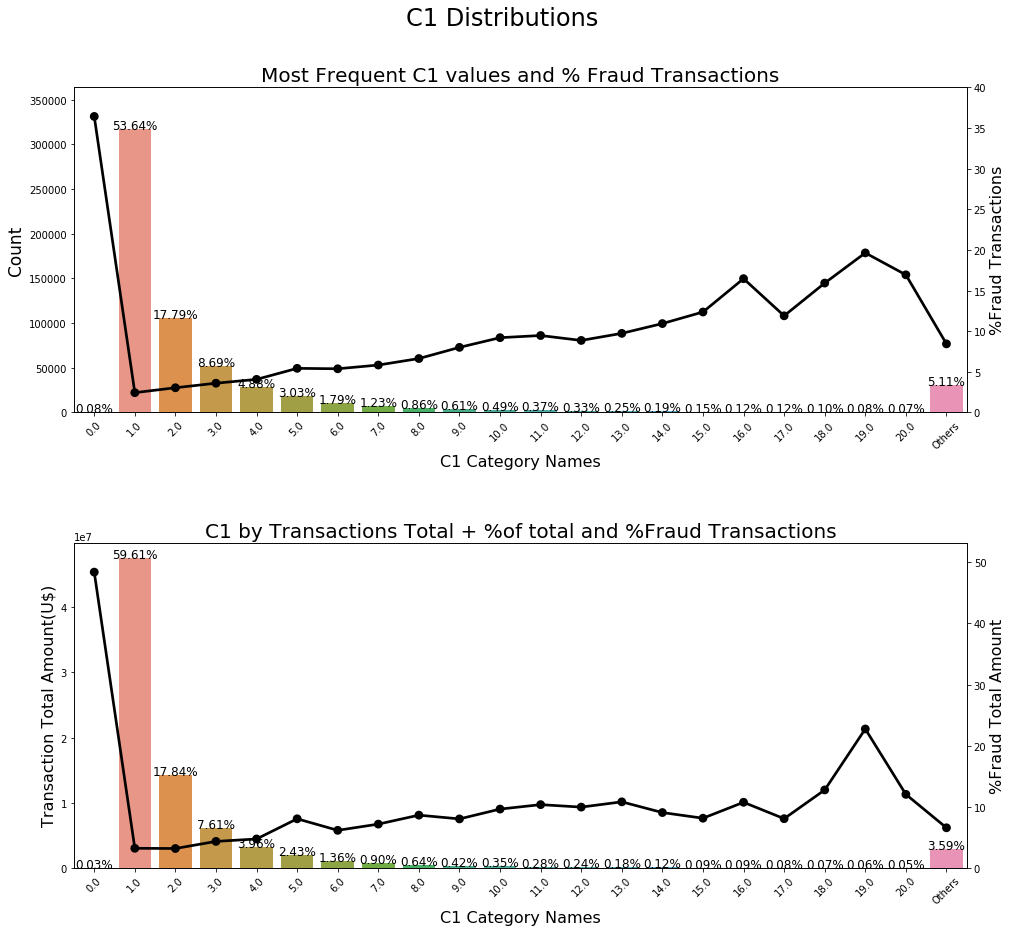

In [32]:
ploting_cnt_amt(df_trans, 'C1')

### C1
- 숫자가 커질수록 차지하는 비율은 감수하고, Fraud %는 증가하는 경향
-  Transaction Amount도 유사한 패턴

In [33]:
df_trans.loc[df_trans['C2'].isin(df_trans['C2'].value_counts()[
    df_trans['C2'].value_counts() <= 350].index), 'C2'] = "Others"

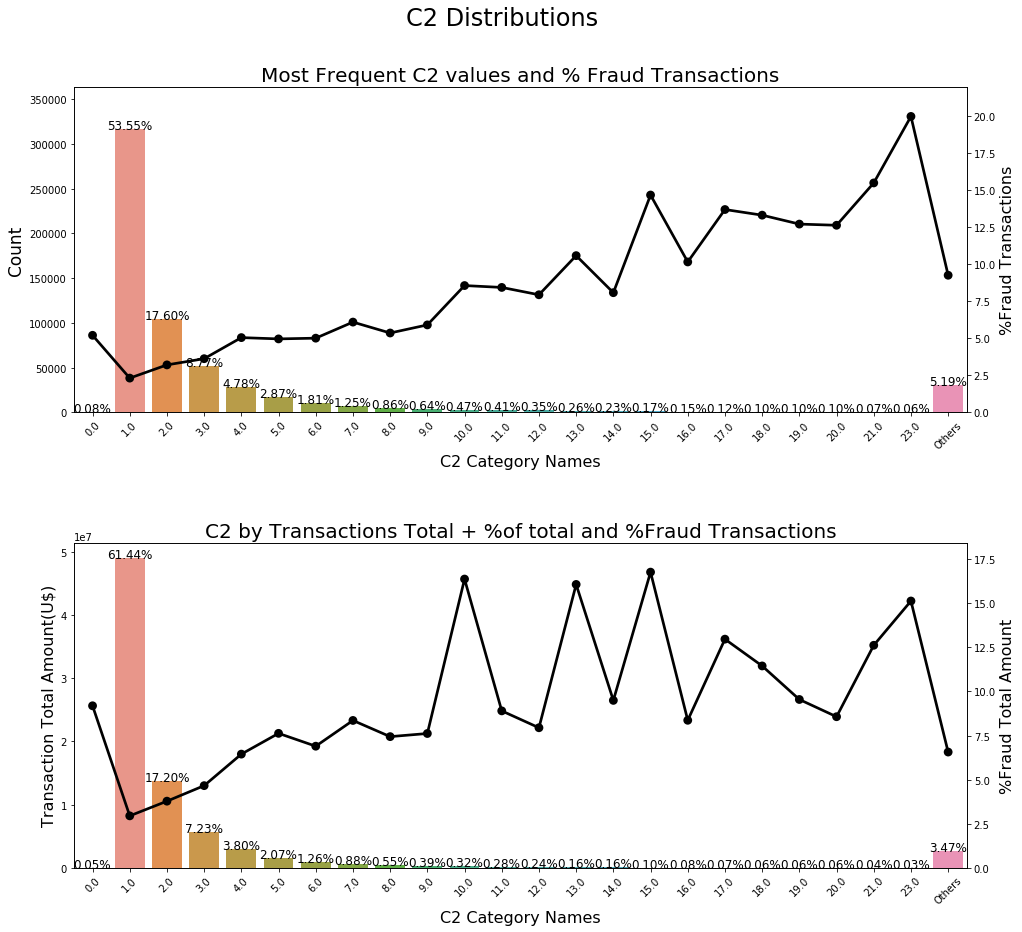

In [34]:
ploting_cnt_amt(df_trans, 'C2')

### C2
- C1과 마찬가지로 숫자가 커질수록 차지하는 비율은 감수하고, Fraud %는 증가하는 경향. Transaction Amount도 유사한 패턴

### 남은 칼럼들
- TransactionDT
- dist1,2
- D1 ~ D15
- V1 ~ V339

In [37]:
print(df_trans.shape[1])
np.array(df_trans.columns)

394


array(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V6

In [42]:
df_trans['TransactionDT'].describe() / 10**5 #십만 단위로 나눔
#최소는 86400, 최대는 1580만 -> 단순히 날짜는 아님.

count      5.905400
mean      73.723113
std       46.172236
min        0.864000
25%       30.270578
50%       73.065275
75%      112.466200
max      158.111310
Name: TransactionDT, dtype: float64

In [48]:
import datetime

START_DATE = "2017-12-01"
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
df_trans['Date'] = df_trans['TransactionDT'].apply(
lambda x: (startdate + datetime.timedelta(seconds = x))) #DT 값은 초??

print(df_trans['Date'].head())

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

0   2017-12-02 00:00:00
1   2017-12-02 00:00:01
2   2017-12-02 00:01:09
3   2017-12-02 00:01:39
4   2017-12-02 00:01:46
Name: Date, dtype: datetime64[ns]


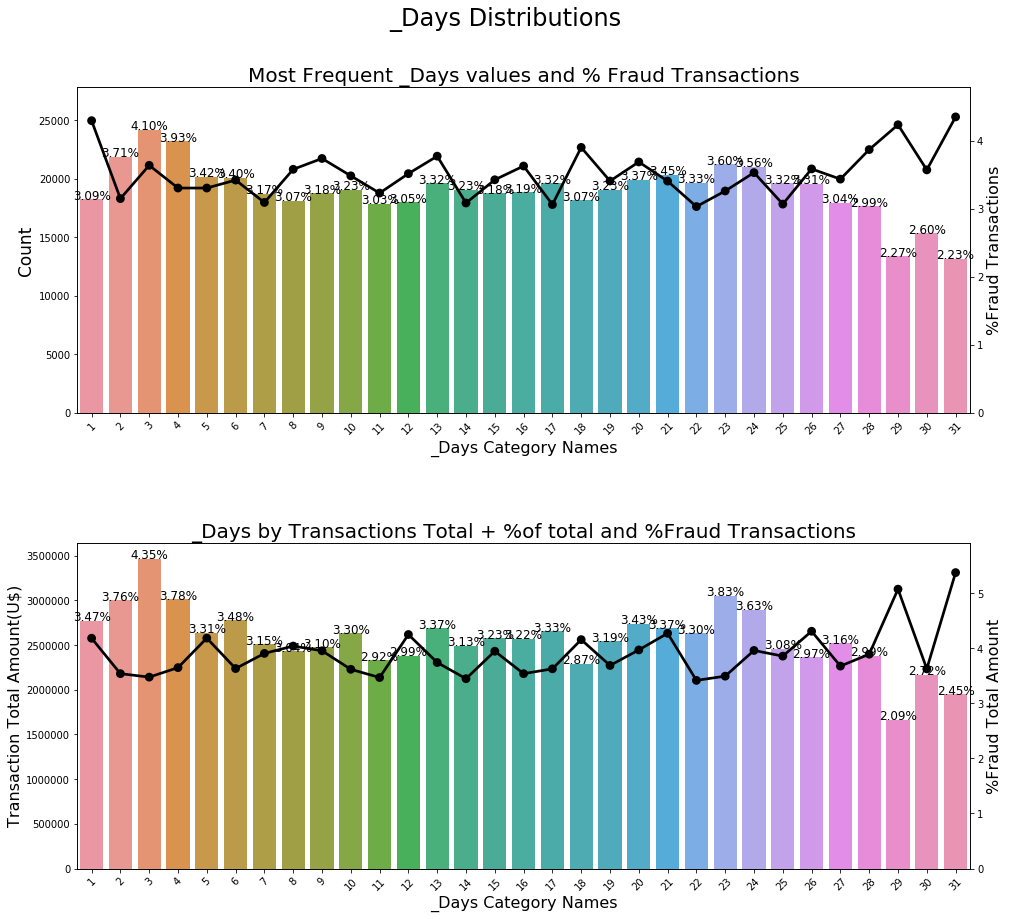

In [49]:
# 일별 그래프
ploting_cnt_amt(df_trans, '_Days')

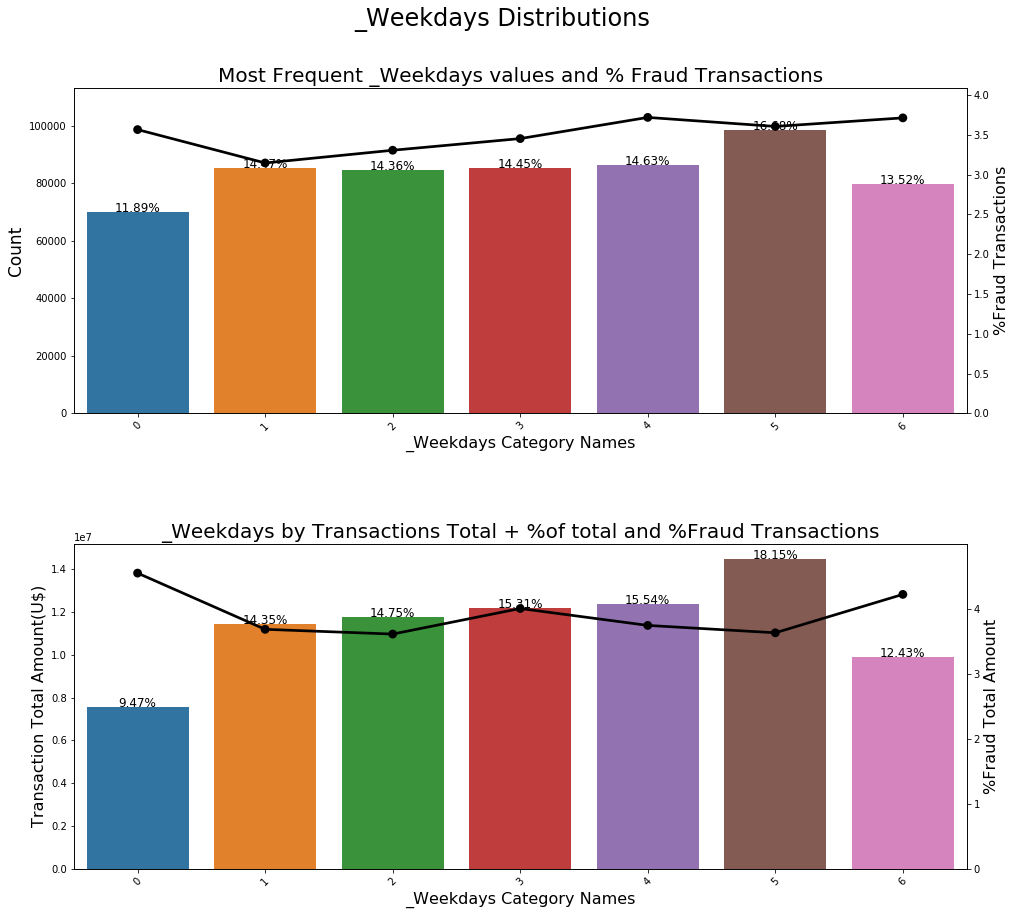

In [50]:
# 요일별 그래프
ploting_cnt_amt(df_trans, '_Weekdays')

### Weekdays
- 주말(0, 6)엔 count와 거래량이 낮음

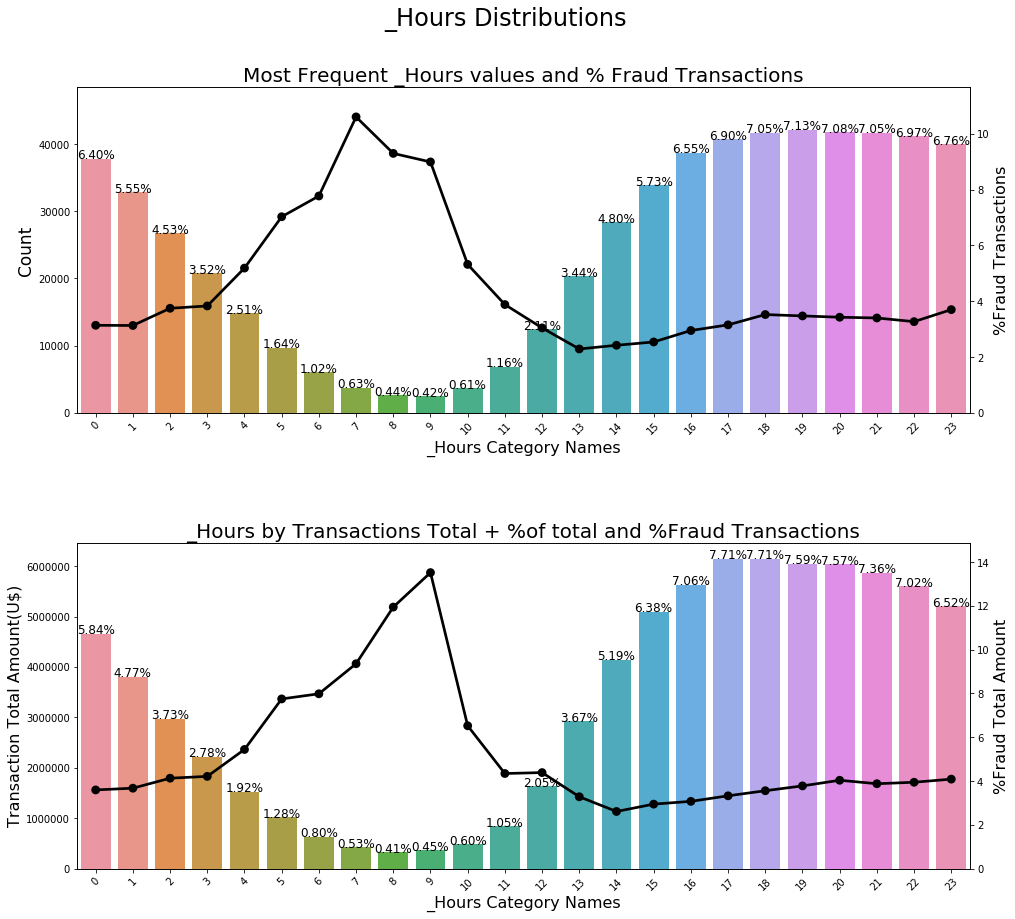

In [51]:
# 시간대별 그래프
ploting_cnt_amt(df_trans, '_Hours')

### Hours
- 거래량과 % Fraud가 정 반대 양상을 보이고 있음. TransactionAmt도 마찬가지

In [52]:
df_trans['Date'].describe()

count                  590540
unique                 573349
top       2018-03-20 15:53:37
freq                        8
first     2017-12-02 00:00:00
last      2018-06-01 23:58:51
Name: Date, dtype: object

In [56]:
#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

dates_temp = df_trans.groupby(df_trans['Date'].dt.date)['TransactionAmt'].count().\
reset_index()

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp['Date'], y=dates_temp['TransactionAmt'],
                  opacity=0.8, line = dict(color = color_op[7]),
                  name = 'Total Transactions')

# Below we will get the total amount sold
dates_temp_sum = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].sum().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.Date, line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1,], layout=layout)

# plotly 패키지의 기능 -> rendering the graphs
iplot(fig) #plt.show()와 같음